<div style="font-size: 60px;padding: 200fpx;">
    
<center>
    
**PROGETTO DMML 2024**
    
<span style="font-size: 30px;padding: 200fpx;">
    
*Data understanding e preparation*
</span>
</center>
    
    
<span style="font-size: 18px;padding: 200fpx;">

Alessandrelli Andrea, Antonini Luca, Cofrancesco Angela
    
</span>

</div>

***
***
***

# **Indice**



<span style="font-size: 18px;">
    
<div class="alert alert-block alert-warning">
    
- [Librerie e funzioni utili](#**Librerie-e-funzioni-utili**)


- [Data understanding](#**Data-understanding**)
    - [Distributions and statistics](##**Distribution-of-the-variables-and-statistics-and-elimination-of-redundant-variables**)
    - [Missing Value](##**Missing-values**)
    - [Outliers e PCA](##**Outliers-e-PCA**)

</div>
</span>

Abbiamo deciso di dividere ogni notebook in due macrosezioni: la prima parte più descrittiva, in cui si tiene traccia attraverso grafici, immagini e parole, dei passaggi e delle strategie adoperate e dei risultati ottenuti, e una seconda parte, complementare alla prima, in cui viene presentato il codice.

***
***
***

# **Librerie e funzioni utili**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import pearsonr
from scipy.stats import norm
import seaborn as sns
# per mostrare tutte le colonne
from IPython.display import display

In [ ]:
# per la normalizzazione e la standardizzazione dei dati
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# utile nel caso fosse necessario applicare la PCA
from sklearn.decomposition import PCA

In [ ]:
# per utilizzare una search più ottimizzata
if False:
    !pip install optuna
import optuna
from optuna.samplers import TPESampler
# per utilizzare la random search e la grid search
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
if False:
    !pip install scikit-plot
# per ottenere le accuracy, la confusion matrix, la ROC curve e il classification report
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
# utile per la Stratified K Fold Cross Validation
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, RepeatedKFold
# per lo split tra training e test set
from sklearn.model_selection import train_test_split

In [ ]:
# per il DecisionTree e i relativi plot
from sklearn.tree import DecisionTreeClassifier, plot_tree
# per la classificazione con Random Forest
from sklearn.ensemble import RandomForestClassifier
# per la regressione lineare
from sklearn.linear_model import LinearRegression, Lasso, Ridge
# per il calcolo degli errori legati alla regressione
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# per salvare i parametri di training
from joblib import dump, load

In [ ]:
import warnings

# Disabilita tutti i warning
warnings.filterwarnings("ignore")

<div style="font-size: 25px;padding: 20fpx;">

**Funzioni utili**
</div>

In [ ]:
# funzione che prende in INPUT una colonna di un dataframe e dà in OUTPUT la percentuale di outliers presenti
def perc_outlier(x):
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3 - q1
    # lista delle colonne con outliers
    outliers = list()
    for v in x:
        if v < q1 - 1.5 * iqr or v > q3 + 1.5 * iqr:
            outliers.append(True)
        else:
            outliers.append(False)

    # restituisce la percentuale di outliers presenti nella colonna x
    return np.array(outliers).sum()/len(x)

In [ ]:
# funzione che restituisce le colonne con correlazione >delta o <delta

def coor_map(df, delta):
    correlation_matrix =df.corr(numeric_only=True)

    # lista con il nome delle due colonne coinvolte e il relativo valore di correlazione
    highly_correlated_columns = list()
    for column in correlation_matrix.columns:
      high_corr = list(correlation_matrix.index[np.abs(correlation_matrix[column]) >= delta])

      high_corr.remove(column)
      for hh in high_corr:
          highly_correlated_columns.append([column, hh, correlation_matrix[column][hh]])
    # ordinamento in base al valore della correlazione
    highly_correlated_columns=sorted(highly_correlated_columns, key= lambda x:x[2], reverse=True)

# eliminazione dei doppioni poiché la coor_matrix è simmetrica
    # Lista per tenere traccia delle tuple già viste
    seen = set()
    filtered_data = []
    for item in  highly_correlated_columns:
    # Ordina la tupla dei primi due elementi in modo da standardizzare l'ordine
        sorted_pair = tuple(sorted(item[:2]))
    # Se la tupla non è già stata vista, aggiunge l'elemento ai dati filtrati e segna la tupla come vista
        if sorted_pair not in seen:
            filtered_data.append(item)
            seen.add(sorted_pair)
# restituisce un array con ogni elemento della forma ['colonna_x', 'colonna_y', correlazione_xy]
    return filtered_data

In [ ]:
# tra le colonne numeriche, salviamo in cc quelle che hanno una percentuale di outliers maggiore del valore soglia
def rimoz_outliers(df, soglia):
    col_num = df.select_dtypes(exclude='bool').columns
    col_da_scartare = []
    for c in col_num:
        controll = perc_outlier(df[c])*100
        if controll > soglia:
            col_da_scartare.append(c)

    df_No_out = df[df.columns.drop(col_da_scartare)]
    return df_No_out

In [ ]:
pd.options.display.max_columns = None # per visualizzare tutte le colonne

---
---
---

<div style="font-size: 20px;padding: 200fpx;">

# **Data understanding**

</div>

***
***

<center>
<div style="font-size: 30px;padding: 200fpx;">

## **Discussione**

</div>

</center>



<div style="background-color: #E1F5FE; border: 2px solid #01579B; padding: 10px; display: block; float: right;">
Il dataset analizzato presenta un totale di 38 attributi e 2452 record.

Dopo un’analisi semantica dei dati, abbiamo scelto di raccogliere le caratteristiche di ogni attributo nella seguente tabella:

<center>
<table>
  <tr style="background-color: #f2f2f2;">
    <th>Nome Variabile</th>
    <th>Tipo</th>
    <th>Descrizione</th>
  </tr>
  
  <tr>
    <td>modality</td>
    <td>Categorico, nominale</td>
    <td>Indica se l'audio è solo vocale o include anche musica</td>
  </tr>

  <tr>
    <td>vocal_channel</td>
    <td>Categorico, nominale [presenta NaN]</td>
    <td>Specifica se l'audio è parlato o cantato</td>
  </tr>

  <tr>
    <td>emotion</td>
    <td>Categorico, nominale</td>
    <td>Rappresenta l'emozione espressa nell'audio</td>
  </tr>

  <tr>
    <td>emotional_intensity</td>
    <td>Categorico, nominale</td>
    <td>Indica l'intensità dell'emozione espressa nell'audio</td>
  </tr>

  <tr>
    <td>statement</td>
    <td>Categorico, nominale</td>
    <td>Riporta la frase pronunciata nell'audio</td>
  </tr>

  <tr>
    <td>repetition</td>
    <td>Categorico, nominale</td>
    <td>Specifica se l'audio è una prima o una seconda ripetizione</td>
  </tr>

  <tr>
    <td>actor</td>
    <td>Categorico, nominale (sotto forma di float) [presenta NaN]</td>
    <td>Identificatore univoco dell'attore che ha registrato l'audio</td>
  </tr>

  <tr>
    <td>sex</td>
    <td>Categorico, nominale</td>
    <td>Specifica il sesso dell'attore</td>
  </tr>

  <tr>
    <td>channels</td>
    <td>Identificativo del canale audio (sotto forma di Intero)</td>
    <td>1 per audio mono e 2 per audio stereo</td>
  </tr>

  <tr>
    <td>sample_width</td>
    <td>Numerico, discreto (sotto forma di Intero)</td>
    <td>Numero di byte per campione</td>
  </tr>

  <tr>
    <td>frame_rate</td>
    <td>Numerico (sotto forma di Intero)</td>
    <td>Frequenza dei campioni audio utilizzati (in Hertz)</td>
  </tr>

  <tr>
    <td>frame_width</td>
    <td>Numerico, continuo (sotto forma di Intero)</td>
    <td>Numero di byte per ogni "frame" audio</td>
  </tr>

  <tr>
    <td>length_ms</td>
    <td>Numerico, continuo (sotto forma di Intero)</td>
    <td>Lunghezza del file audio in millisecondi</td>
  </tr>

  <tr>
    <td>frame_count</td>
    <td>Numerico, continuo</td>
    <td>Numero di frame nell'audio</td>
  </tr>

  <tr>
    <td>intensity</td>
    <td>Numerico [presenta NaN]</td>
    <td>Decibel rispetto al massimo livello di volume</td>
  </tr>


  <tr>
    <td>zero_crossings_sum</td>
    <td>Numerico (sotto forma di Intero)</td>
    <td>Totale del numero di volte in cui il segnale audio attraversa lo zero</td>
  </tr>



  <tr>
    <td>mean, std, min, max, kur, skew</td>
    <td>Numerico, continuo</td>
    <td>media, deviazione standard, minimo, massimo, curtosi e skewness del file audio</td>
  </tr>


  <tr>
    <td>stft_ 'mean', 'std', 'min', 'max', 'kur', 'skew'</td>
    <td>Numerico, continuo</td>
    <td>media, deviazione standard, minimo, massimo, curtosi e skewness della Short-Time Fourier Transform (STFT) del Chromagram</td>
  </tr>

  <tr>
    <td>mfcc_ 'mean', 'std', 'min', 'max</td>
    <td>Numerico, continuo</td>
    <td>media, deviazione standard, minimo e massimo del Mel-Frequency Cepstral Coefficients (MFCCs)</td>
  </tr>

  <tr>
    <td>sc_ 'mean', 'std', 'min', 'max', 'kur', 'skew'</td>
    <td>Numerico, continuo</td>
    <td>media, deviazione standard, minimo, massimo, curtosi e skewness dello Spectral Centroid (SC)</td>
  </tr>
</table>

</center>


**Attributi NON informativi (valori costanti)**

Si è subito proceduto a una prima analisi per vedere se ci fossero colonne superflue. In particolare si è verificata la presenza, in primo luogo, di colonne con la presenza di un unico valore e si è proceduto alla loro eliminazione. In particolare, abbiamo quindi eliminato le colonne:


*   'modality'
*   'sample_width'
*   'frame_rate'
*   'stft_max'

**Valori perfettamente correlati**

Un altro check che si è subito svolto ha riguardato l'eventuale presenza di coppie di attributi con correlazione lineare pari a $\pm 1$. Questa condizione si è effettivamente verificata per le colonne 'channel' e 'frame_width'. Abbiamo quindi deciso di tenere solo una delle due colonne (abbiamo conservato 'frame_width')

**Valori anomali**

Andando a ispezionare l'eventuale presenza di valori anomali nei dati si è notato, poi, come la colonna 'frame_count' presentasse dei record con valori pari a $-1$ che ovviamente sono da considerarsi errati. Per ovviare a questa inconsistenza dei dati, abbiamo notato come, escludendo le osservazioni anomale, la correlazione lineare tra 'frame_count' e 'length_ms' fosse pari a $1$, quindi, sfruttando questa correlazione abbiamo deciso di conservare solo la variabile 'length_ms' e di eliminare 'frame_count', risolvendo, di conseguenza, anche l'inconsistenza dei dati.


**Valori fortemente sbilanciati in 'frame_width'**

Analizzando la colonna 'frame_width' notiamo come questa sia fortemente sbilanciata verso il valore 2 (99.75% dei casi) rispetto al valore 4 (0.25% dei casi). Pertanto, per le future analisi, scegliamo di eliminare le 6 righe dove appare il valore 4 e successivamente di droppare l'intera colonna.


**Missing Value**

*   **Intensity**: per inferire i missing value presenti (circa il 33% dei record presenti) si è proceduto con una regressione lineare, sfruttando l'altissima correlazione lineare (superiore a 0.96) che era presente tra l'attributo in esame e gli attributi 'mfcc_std' e 'mfcc_min'.
  
  Riportiamo di seguito i plot delle distribuzioni, e gli scatter plot rispetto a 'mfcc_std' e 'mfcc_min' sia della viariabile 'intensity' originale (in blu) che di quella con i NaN, riempiti con i valori ottenuti dalla regressione lineare (in verde);

  </div>

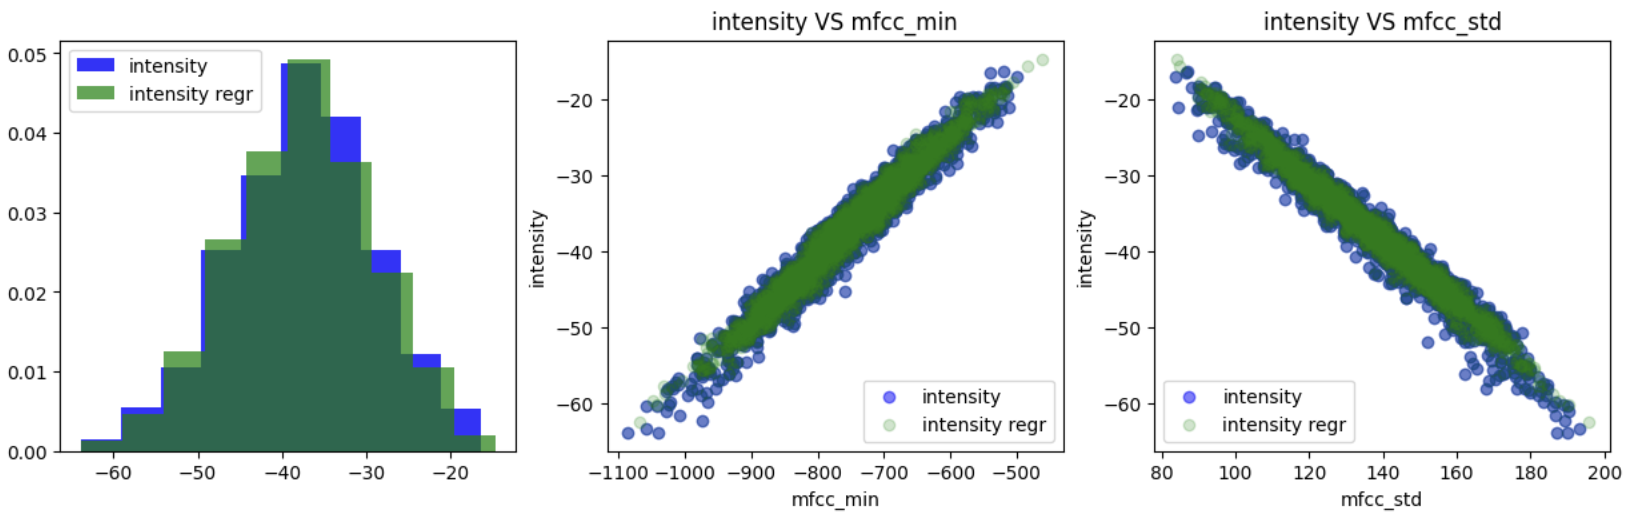

Da sinistra a destra: istogramma della distribuzione dell'attributo 'intensity' originale (blu) e dopo aver eliminato i missing value utilizzando la regressione lineare (verde); scatter plot dell'attributo 'intensity' rispetto agli attributi ad esso fortemente linearmente correlati 'mfcc_min' e 'mfcc_std'


<div style="background-color: #E1F5FE; border: 2px solid #01579B; padding: 10px; display: block; float: right;">

*   **Vocal_channel**: per inferire i missing value presenti (circa lo 8% dei record) si è proceduto ad allenare su tutti gli altri attributi un Random Forest. Riportiamo la confusion matrix e le curve ROC e Precision-Recall per il Random Forest, usato per inferire i valori mancanti in 'vocal_channel'

</div>

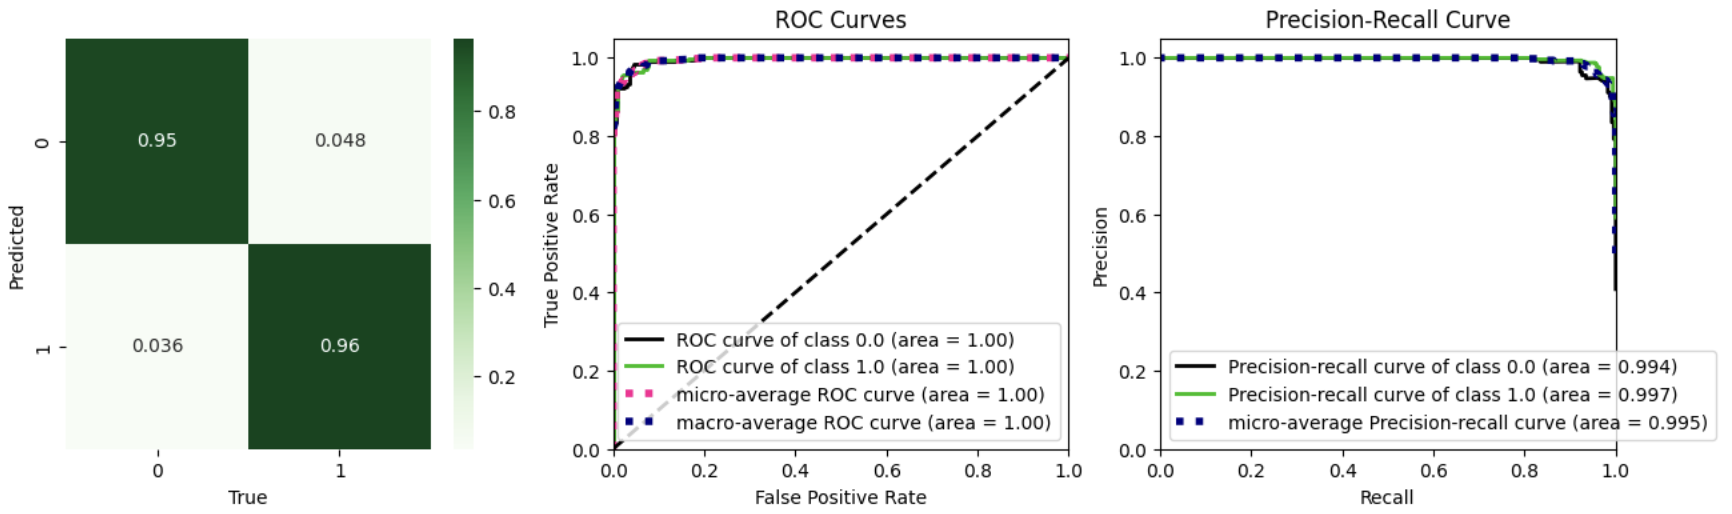


Da sinistra a destra: confusion matrix, ROC curve e precision-recall curve ottenute dal random forest model allenato per andare a inferire i valori mancanti dell'attributo 'vocal_channel'. Tutti e tre i plot sono ottenuti utilizzando esclusivamente il test set.


<div style="background-color: #E1F5FE; border: 2px solid #01579B; padding: 10px; display: block; float: right;">


*   **Actor**: poichè poco influente ai fini delle nostre analisi e presentando quasi il 45% di missing values si è scelto di eliminare tale colonna.

**Outliers**

Per ridurre sensibilmente il numero di outliers presenti delle colonne:
* 'kur'
* 'sc_kur'
* 'stft_kur'

si è shiftata indietro la kurtosi addizionando $+3$ e poi si è proceduto ad applicare una trasformazione logaritmica ai dati.

Per le colonne di tipo:
* 'std'
* 'sc_std'
* 'stft_std'
* 'mfcc_std'

invece si è applicata direttamente una trasformazione di tipo logaritmico. Inoltre per l'altissima presenza di outliers si è selto di eliminare la colonna 'mean'.



**PCA**

Nell' ottica di ridurre la dimensionalità del nostro dataset, dopo aver applicato uno StandardScaler a tutte le variabili di tipo numerico, e dopo aver estratto le coppie di variabili che presentavano una correlazione lineare superiore a 0.8 (['max', 'mfcc_std', 'min', 'sc_kur', 'stft_mean', 'sc_mean','intensity', 'stft_skew', 'mfcc_min', 'sc_skew','std']), si e proceduto ad applicare una PCA con n=3. Tale trasformazione ci consente di *condensare* le 11 variabili precedentemente elencate in sole 3 nuove variabili, che abbiamo denominato ['PCA1', 'PCA2', 'PCA3'] e che insieme spiegano lo 0.92% della varianza delle precedenti 11.

</div>

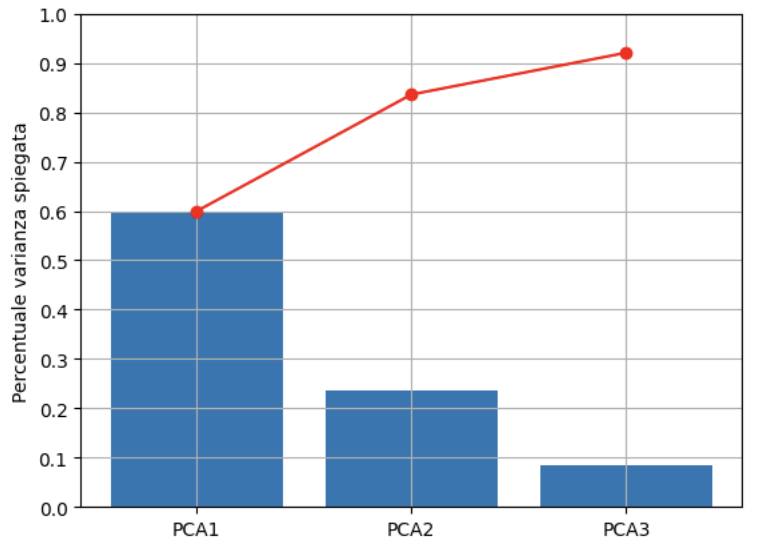

   Percentuale della varianza spiegata dalle tre componenti della PCA rispetto alle 11 variabili originali ['max', 'mfcc_std', 'min', 'sc_kur', 'stft_mean', 'sc_mean','intensity', 'stft_skew', 'mfcc_min', 'sc_skew','std']

<div style="background-color: #E1F5FE; border: 2px solid #01579B; padding: 10px; display: block; float: right;">


Alla fine di questa prima parte di preparazione dei dati, siamo riusciti a ridurre la dimensionalità del dataset da 38 a soli 19 attributi. Abbiamo salvato il nuovo dataset nel file csv *'data_esame_trasformato.csv'*.

</div>

***
***
***

<center>
<div style="font-size: 30px;padding: 200fpx;">

## **Codice**


</div>
</center>

In [ ]:
df_completo = pd.read_csv('data/ravdess_features.csv', sep=',', skipinitialspace=True)
df_completo.head()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,frame_rate,frame_width,length_ms,frame_count,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
0,audio-only,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F,1,2,48000,2,3737,179379.0,-36.793432,16995,-33.485947,134.654860,-755.22345,171.69092,5792.550744,3328.055457,0.0,13541.959028,-1.120769,0.250940,0.415250,0.335533,0.0,1.0,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153
1,audio-only,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F,1,2,48000,2,3904,187387.0,NaN,13906,-29.502108,130.485630,-713.98560,205.00770,5197.620555,4040.931570,0.0,12000.290443,-1.531204,0.219582,0.417488,0.352380,0.0,1.0,-1.384174,0.290905,-7.149491e-08,0.020417,-0.305725,0.263062,19.564187,0.292157
2,audio-only,NaN,happy,strong,Dogs are sitting by the door,2nd,16.0,F,1,2,48000,2,4671,224224.0,-32.290737,18723,-30.532463,126.577110,-726.06036,165.45653,4830.743037,3332.131300,0.0,12007.751173,-1.130153,0.436699,0.379758,0.352270,0.0,1.0,-1.242947,0.470350,2.429985e-06,0.024317,-0.137482,0.166351,4.881241,0.302659
3,audio-only,NaN,surprised,normal,Kids are talking by the door,1st,14.0,F,1,2,48000,2,3637,174575.0,-49.019839,11617,-36.059555,159.725160,-842.94635,190.03609,5376.446478,4053.663073,0.0,12048.223893,-1.497765,0.098802,0.407277,0.360552,0.0,1.0,-1.445318,0.274756,2.373929e-07,0.003561,-0.027374,0.024078,13.040259,-0.081014
4,audio-only,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F,1,2,48000,2,4404,211411.0,-31.214503,15137,-31.405996,122.125824,-700.70276,161.13400,5146.012474,3442.724109,0.0,12025.582707,-1.167544,0.496066,0.415974,0.350655,0.0,1.0,-1.366742,0.318926,8.454691e-07,0.027522,-0.192169,0.242676,7.485109,0.414872


In [ ]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   modality             2452 non-null   object 
 1   vocal_channel        2256 non-null   object 
 2   emotion              2452 non-null   object 
 3   emotional_intensity  2452 non-null   object 
 4   statement            2452 non-null   object 
 5   repetition           2452 non-null   object 
 6   actor                1326 non-null   float64
 7   sex                  2452 non-null   object 
 8   channels             2452 non-null   int64  
 9   sample_width         2452 non-null   int64  
 10  frame_rate           2452 non-null   int64  
 11  frame_width          2452 non-null   int64  
 12  length_ms            2452 non-null   int64  
 13  frame_count          2452 non-null   float64
 14  intensity            1636 non-null   float64
 15  zero_crossings_sum   2452 non-null   i

In [ ]:
df_completo.describe(include="all")

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,frame_rate,frame_width,length_ms,frame_count,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
count,2452,2256,2452,2452,2452,2452,1326.000000,2452,2452.000000,2452.0,2452.0,2452.000000,2452.000000,2452.000000,1636.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.0,2452.000000,2452.000000,2.452000e+03,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000
unique,1,2,8,2,2,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,audio-only,speech,fearful,normal,Dogs are sitting by the door,2nd,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2452,1335,376,1320,1226,1226,NaN,1248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,12.582202,NaN,1.002447,2.0,48000.0,2.004894,4092.151305,193587.188010,-37.625332,12885.314029,-28.769180,136.777233,-758.909381,199.182514,5170.101398,3365.453393,551.834124,11830.461864,-1.142642,0.348442,0.475846,0.331371,0.002272,1.0,-1.247929,0.112889,1.393649e-08,0.020504,-0.164871,0.179839,11.203002,-0.048245
std,NaN,NaN,NaN,NaN,NaN,NaN,6.916240,NaN,0.049416,0.0,0.0,0.098833,598.321526,36825.369056,8.451982,3665.319584,4.461886,20.451689,99.945452,26.002107,875.185444,580.479034,508.025890,1004.955976,0.572654,0.353005,0.082551,0.023773,0.004830,0.0,0.211781,0.330759,4.267587e-05,0.021024,0.175443,0.195539,6.614859,0.454925
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,2.0,48000.0,2.000000,2936.000000,-1.000000,-63.864613,4721.000000,-43.812923,83.621370,-1085.479700,126.250810,2360.880942,1491.341071,0.000000,7657.495158,-1.795576,-0.510390,0.214089,0.210126,0.000000,1.0,-1.669603,-0.993957,-9.435575e-04,0.000652,-0.998810,0.004669,1.757794,-2.356526
25%,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,1.000000,2.0,48000.0,2.000000,3604.000000,172972.000000,-43.539869,10362.500000,-31.828597,122.623928,-826.464075,180.081417,4563.684781,3025.431971,0.000000,11516.034429,-1.496187,0.098549,0.415260,0.317780,0.000000,1.0,-1.390612,-0.094334,-1.394488e-06,0.006791,-0.202431,0.055489,6.519988,-0.336624
50%,NaN,NaN,NaN,NaN,NaN,NaN,13.000000,NaN,1.000000,2.0,48000.0,2.000000,4004.000000,190591.000000,-37.072745,12383.500000,-28.681109,136.523810,-760.983065,201.697175,5122.712259,3433.835368,707.319256,12000.292653,-1.308938,0.347621,0.475740,0.334224,0.000190,1.0,-1.292105,0.126065,-9.810701e-08,0.013880,-0.103775,0.109726,9.828686,0.004256
75%,NaN,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,1.000000,2.0,48000.0,2.000000,4538.000000,217817.000000,-31.591309,14966.000000,-25.550238,151.385135,-692.890015,218.185288,5775.959809,3768.503344,977.693852,12091.886054,-0.982944,0.557427,0.530571,0.349272,0.001999,1.0,-1.152519,0.335574,8.363511e-07,0.026154,-0.054352,0.224487,14.085435,0.262978


***

### **Distribuzioni, statisiche descrittive e pulizia**

<div style="font-size: 18px">


> Procediamo all'eliminazione delle colonne con un unico valore presente essendo poco utili al fine della classificazione ed analisi del dataset


</div>

In [ ]:
# salvo in 'colonne_con_std_NULLA' tutte le colonne che presentano un solo tipo di record e che non hanno valori nan al loro interno
colonne_con_std_NULLA = []
for c in df_completo.columns:
    if len(df_completo[c].unique()) == 1 and df_completo[c].isna().sum()==0 :
        colonne_con_std_NULLA.append(c)

# elimino le colonne in 'colonne_con_std_NULLA' poichè non danno alcuna info utile essendo tutte uguali per ogni record

df_completo.drop(columns=colonne_con_std_NULLA, inplace =True)

print('Colonne eliminate poichè presentavano un solo valore:\n')
print(f"\t\t{colonne_con_std_NULLA}")

Colonne eliminate poichè presentavano un solo valore:

		['modality', 'sample_width', 'frame_rate', 'stft_max']


<div style="font-size: 18px">



> Procediamo alla verifica ed eliminazione di eventuli colonne che hanno un valore di correlazione pari a $\pm 1$


</div>

In [ ]:
# usando la funzione coor_map da noi definita, andiamo a vedere se ci sono variabili perfettamente correlate
col_corr = coor_map(df_completo, 1)
colonne_high_corr = list()
for x in col_corr:
    colonne_high_corr.append(x[0:2])
# risulta esserci una correlazione perfetta tra 'channels' e 'frame_width'
colonne_high_corr

[['channels', 'frame_width']]

In [ ]:
# scegliamo di eliminare 'channels'
df_completo.drop('channels', axis=1, inplace=True)



> Verifichiamo la presenza di valori anomali nelle colonne del dataset $⟹$ notiamo che 'frame_count' presenta anche valori negativi, il che non ha senso poiché il numero di frame di un segnale audio non può essere negativo.



In [ ]:
# andiamo a vedere se ci sono valori di 'frame count' negativi e la loro percentuale
df_completo[df_completo['frame_count']<0]['frame_count'].value_counts()*100/len(df_completo)

frame_count
-1.0    1.427406
Name: count, dtype: float64

ma si può notare, tuttavia, come restingendoci ai soli valori positivi di 'frame_count' (df[df['frame_count']>0]), questa variabile è in
perfetta correlazione con 'length_ms'

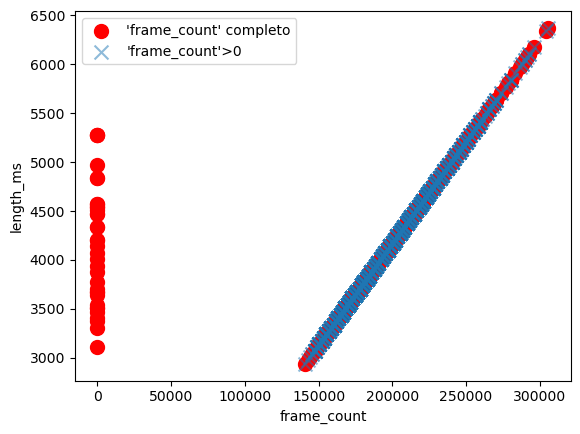

length_ms      1.0
frame_count    1.0
Name: frame_count, dtype: float64

In [ ]:
# calcoliamo la matrice di correlazione tra le due variabili, restringendoci alle righe con 'frame_count'>0
index_fc_pos = df_completo['frame_count']>0
corr_fc_pos =df_completo[index_fc_pos].corr(numeric_only=True)

index_high_corr_fc = corr_fc_pos['frame_count']>0.99


# la perfetta correlazione tra queste due variabili è lampante anche usando uno scatter plot
plt.scatter(df_completo['frame_count'],df_completo['length_ms'], c='r', s= 100, label = '\'frame_count\' completo')
plt.scatter(df_completo[index_fc_pos]['frame_count'],df_completo[index_fc_pos]['length_ms'],alpha=0.5 , s= 100,marker='x',label = '\'frame_count\'>0')
plt.xlabel('frame_count')
plt.ylabel('length_ms')
plt.legend()
plt.show()

# printiamo il valore della matrice di correlazione tre le due variabili
corr_fc_pos['frame_count'][index_high_corr_fc]

In [ ]:
# poichè le due variabili sono perfettamente correlate in modo lineare scegliamo di tenere solo 'length_ms'
df_completo.drop(columns='frame_count', inplace = True)

<div style="font-size: 18px">


> Per i nostri scopi, inoltre, la colonna 'actor' è poco utile e influisce relativamente poco nelle analisi successive $\Longrightarrow$ scegliamo di eliminarla


</div>

In [ ]:
df_completo.drop(columns='actor', inplace = True)

<div style="font-size: 18px">



> Analizzando la colonna 'frame_width' notiamo come questa sia fortemente sbilanciata verso il valore 2 (99.75% dei casi) rispetto al valore 4 (0.25% dei casi). Pertanto, per le future analisi, scegliamo di eliminare le 6 righe dove appare il valore 4 e successivamente di droppare l'intera colonna.


</div>

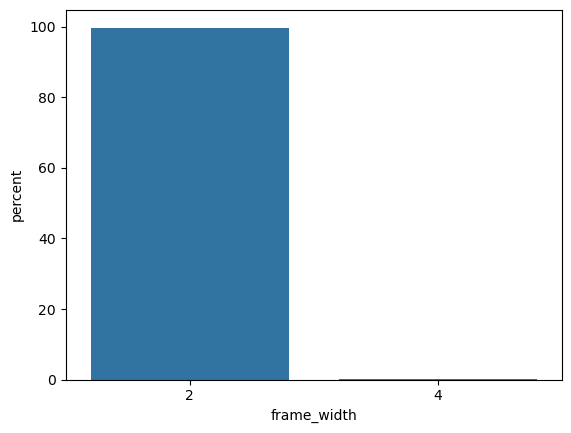

frame_width
2    2446
4       6
Name: count, dtype: int64
frame_width
2    0.997553
4    0.002447
Name: proportion, dtype: float64


In [ ]:
sns.countplot(df_completo, x='frame_width', stat='percent')
plt.show()
# conteggi assoluti dei possibili valori della variabile
print(df_completo['frame_width'].value_counts())

# conteggio in percentuale
print(df_completo['frame_width'].value_counts(normalize=True))

In [ ]:
# conserviamo solo le righe che presentano il valore dominante di 'frame_width'
# e successivamente droppiamo via l'intera colonna (essendo ora costituita du un unico valore)
df_completo = df_completo[df_completo['frame_width']==2]

# elimino tutta la colonna
df_completo.drop(columns='frame_width', inplace = True)

<div style="font-size: 18px">


> Andiamo a visualizzare come si distribuiscono sia gli attributi continui che quelli categorici


</div>

In [ ]:
# creo un sotto dataset formato da sole variabili categoriche
df_colonnes_categ = df_completo.select_dtypes(include='object')

# salvo la lista delle variabili numeriche
colonnes_num = df_completo.columns.drop(df_colonnes_categ)


# salvo le colonne categoriche includendo anche 'actor'
col_categoriche=list(df_colonnes_categ.columns)

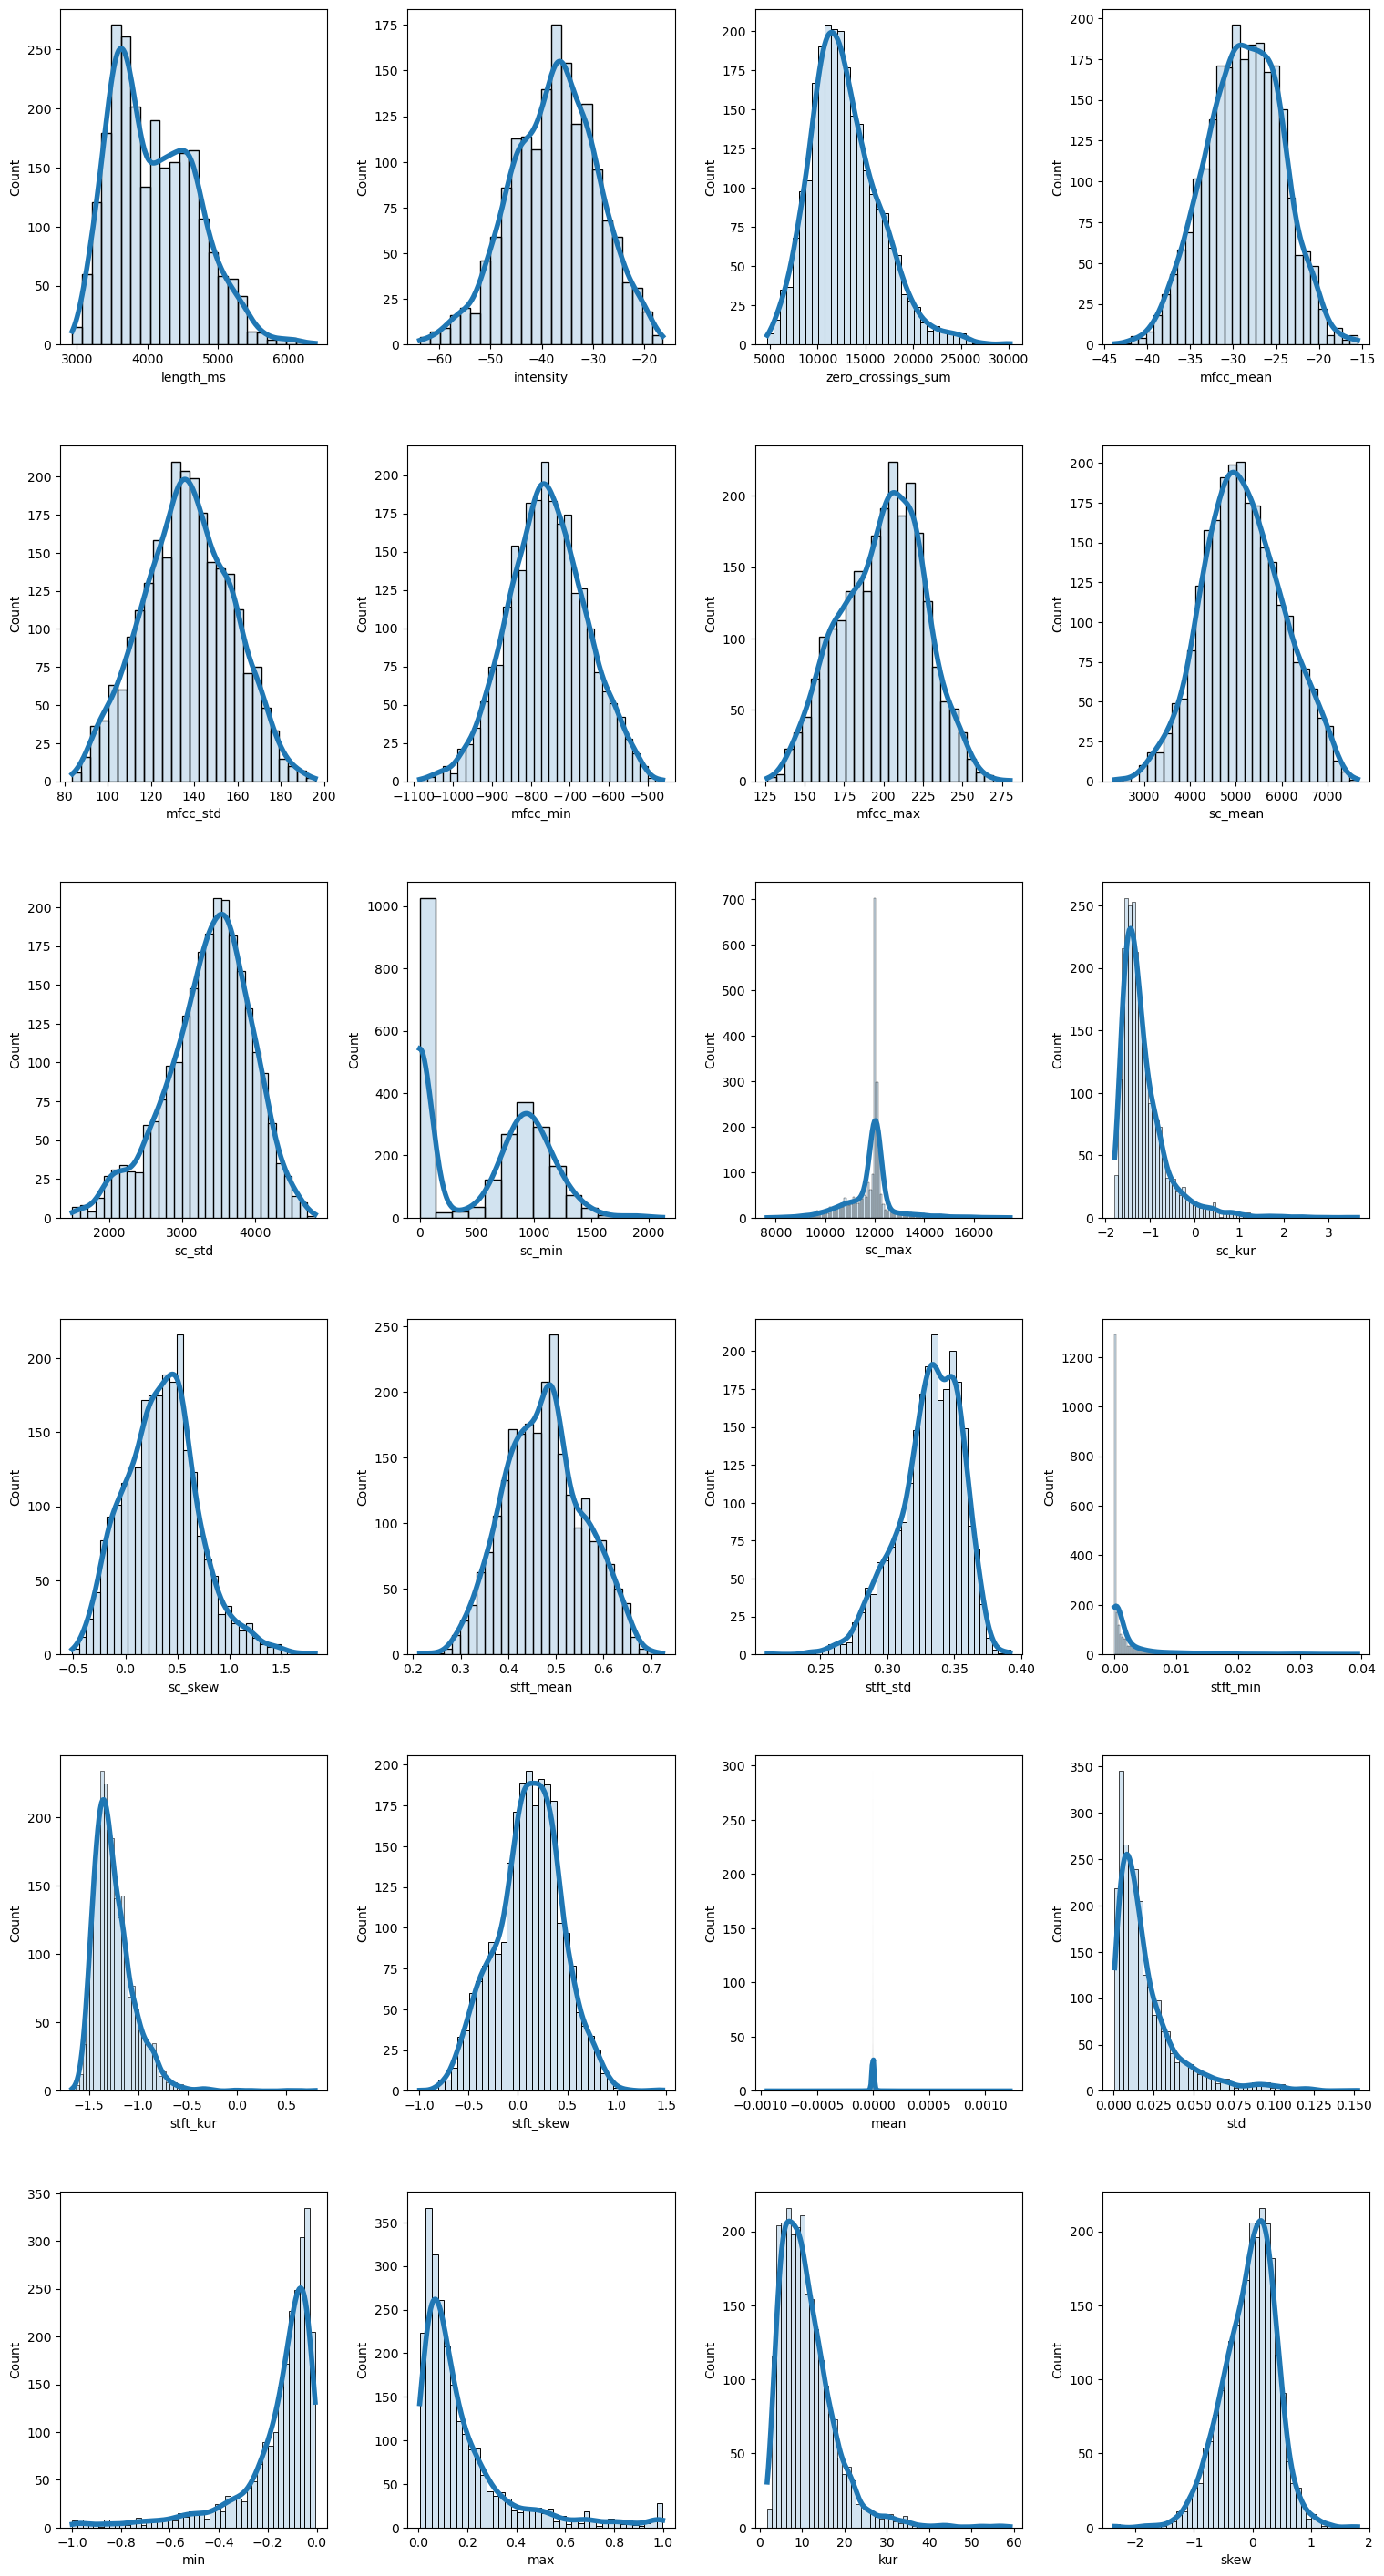

In [ ]:
# istogrammi delle variabili numeriche
j = 0
i=0
fig, axs = plt.subplots(6, 4, figsize=(25, 35))
for c in colonnes_num:
    sns.histplot(data=df_completo, x=c, kde=True, line_kws={'color': 'r', 'linewidth': 4}, alpha=0.2, ax=axs[j,i])
    i += 1
    if i%4==0:
        j+=1
        i=0



plt.subplots_adjust(right=0.7, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


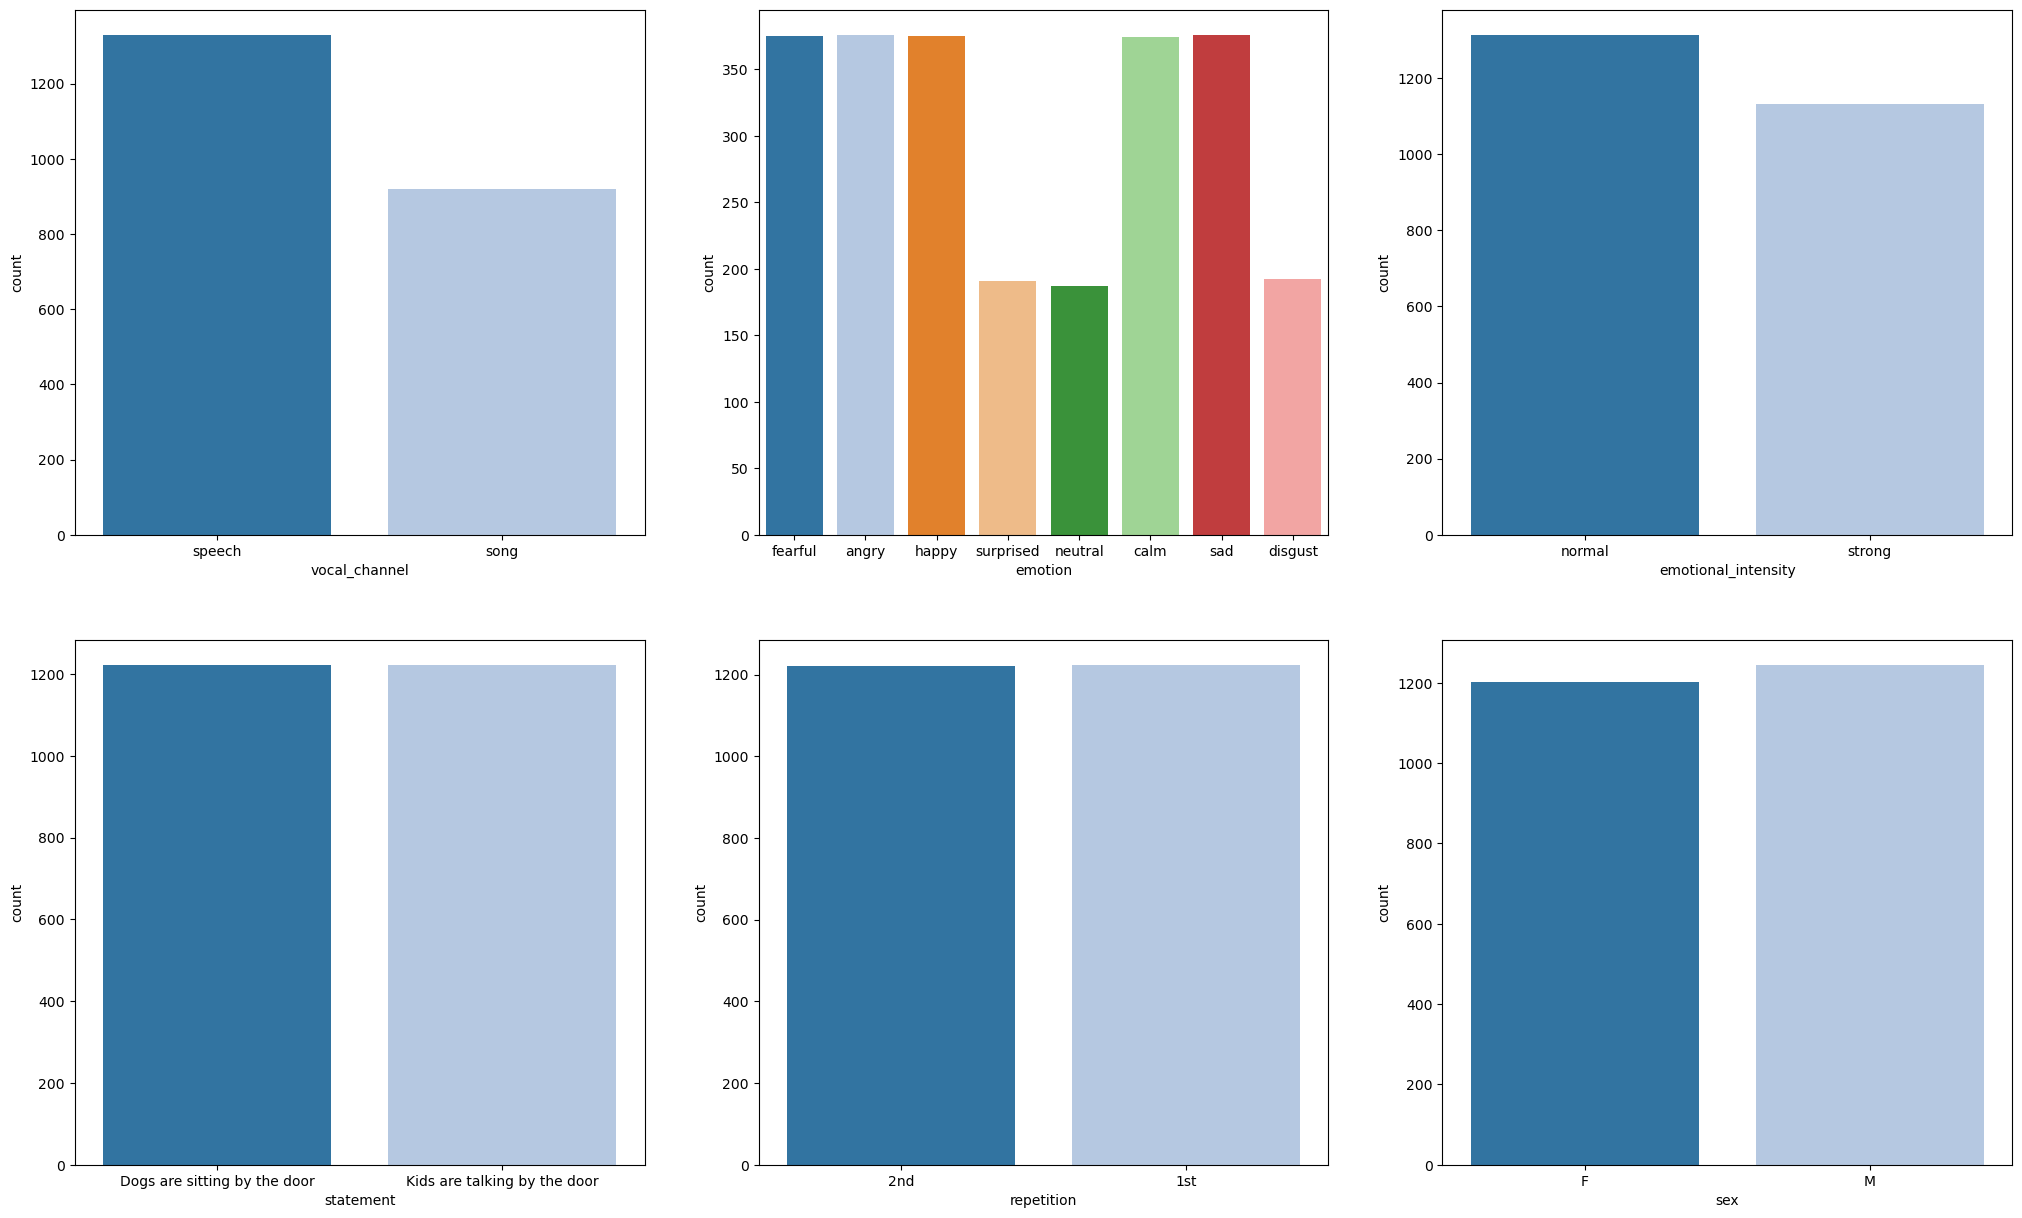

In [ ]:
# countplot delle variabili categoriche
paletta_estesa= sns.color_palette('tab20', n_colors=20) + sns.color_palette('tab20b', n_colors=4)
fig, axs = plt.subplots(2, 3, figsize=(25, 15))
i=0
j=0
for c1 in col_categoriche:
    sns.countplot(data=df_completo, x=c1, hue = c1, palette=paletta_estesa[:len(df_completo[c1].unique())], ax=axs[j,i])
    axs[j,i].legend().remove()
    i += 1
    if i%3==0:
        j+=1
        i=0
plt.show()



> Avendo in mente di andare a creare un classificatore che distingua le varie emozioni presenti nel dataset, ora andiamo a distinguere i vari attributi dividendoli in base alla colonna 'emotion'



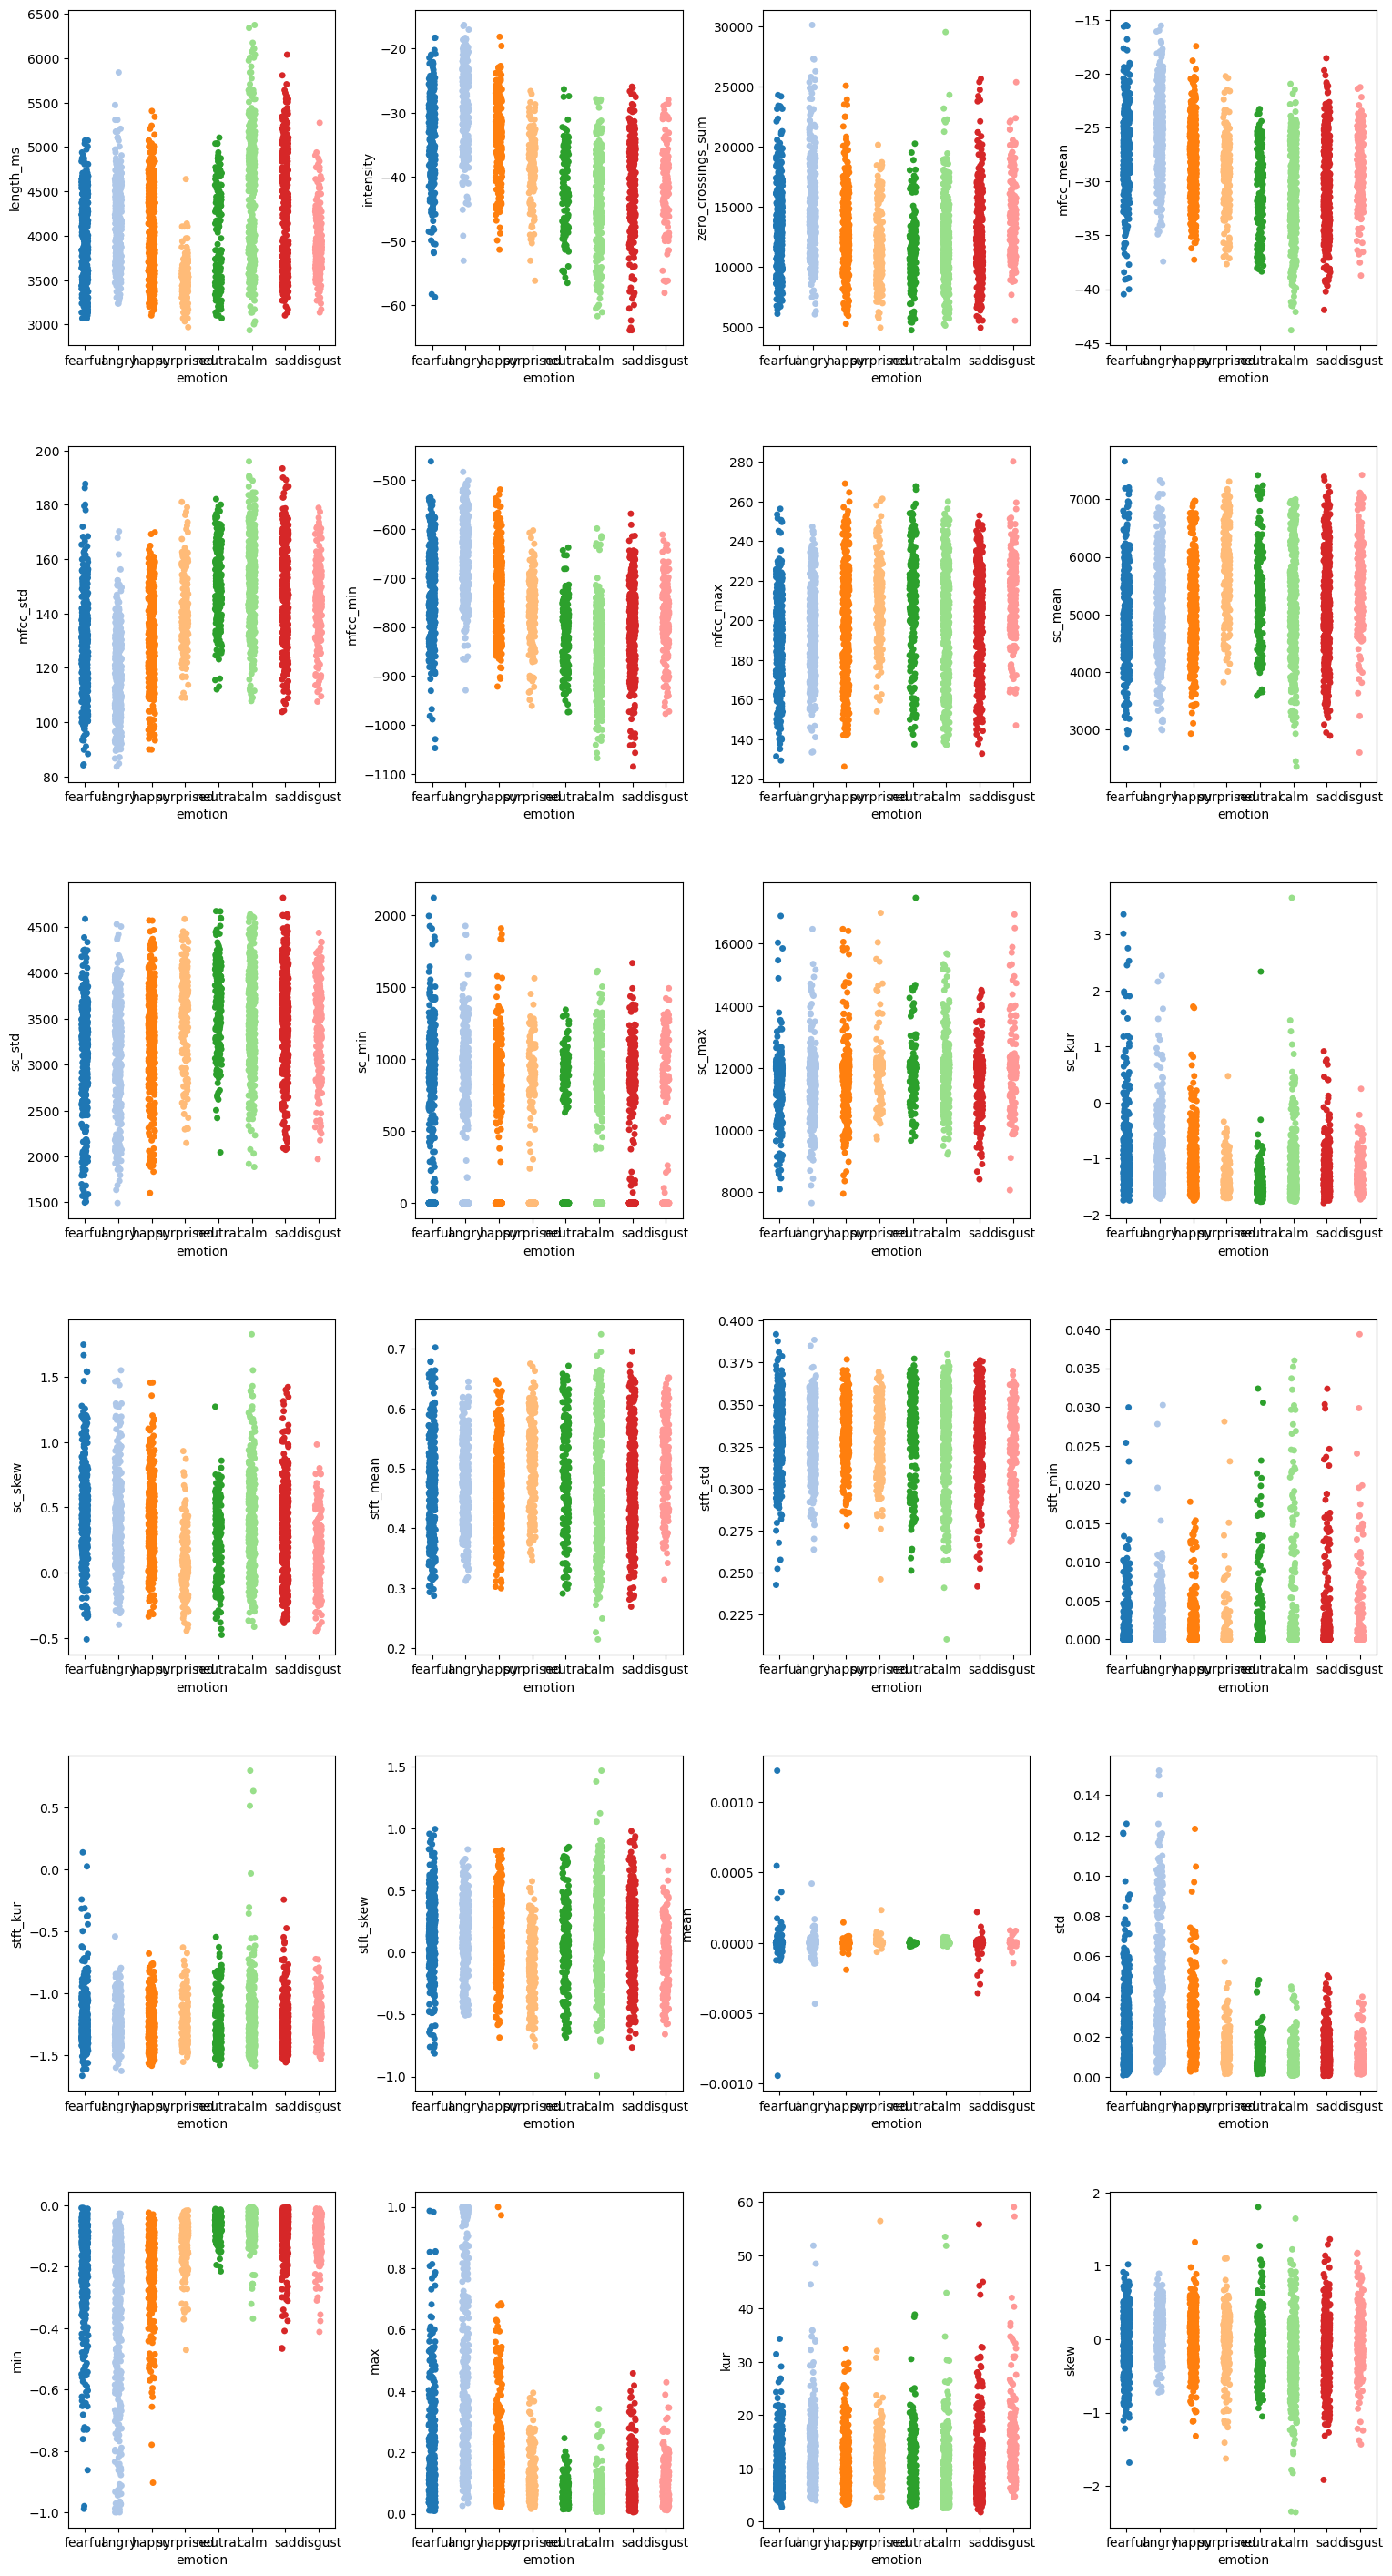

In [ ]:
j = 0
i=0
fig, axs = plt.subplots(6, 4, figsize=(25, 35))
for c in colonnes_num:
    sns.stripplot(data=df_completo, x="emotion", y=c, ax=axs[j,i], hue="emotion", palette='tab20', legend=None)
    i += 1
    if i%4==0:
        j+=1
        i=0


plt.subplots_adjust(right=0.7, top=0.9, wspace=0.3, hspace=0.3)

plt.show()

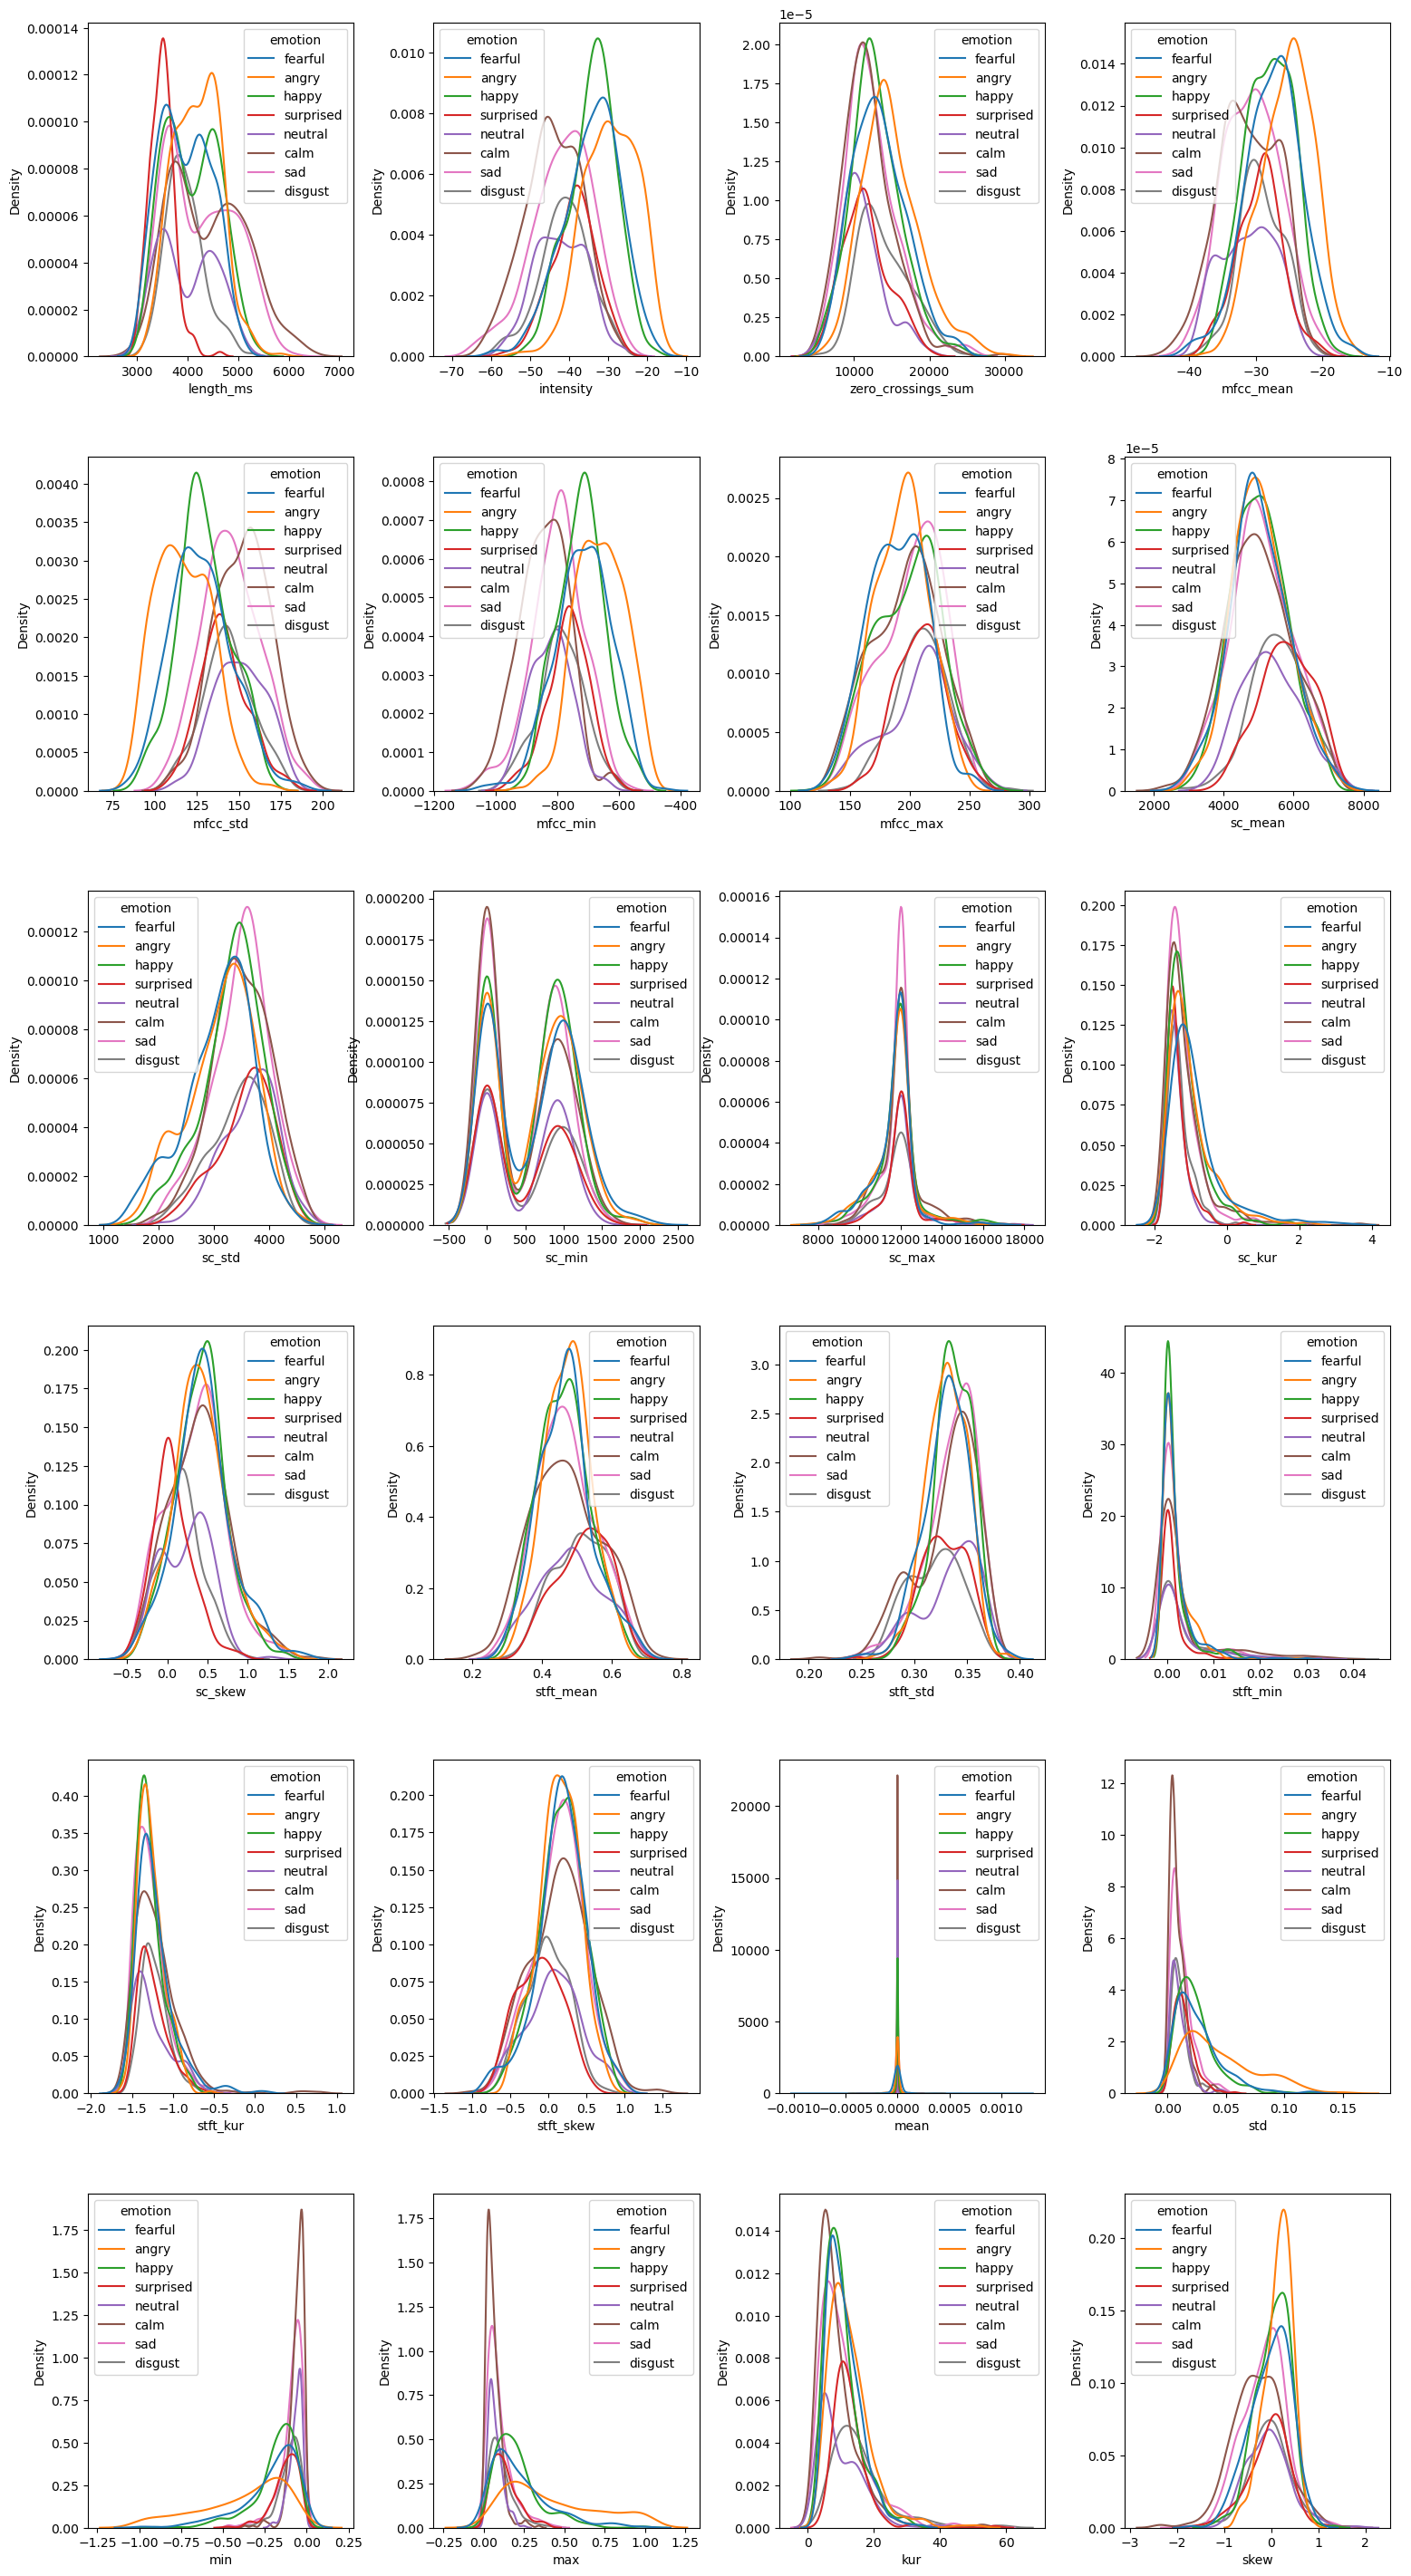

In [ ]:
j = 0
i=0
fig, axs = plt.subplots(6, 4, figsize=(25, 35))
for c in colonnes_num:
    sns.kdeplot(data=df_completo, hue="emotion", x=c, ax=axs[j,i])
    i += 1
    if i%4==0:
        j+=1
        i=0



plt.subplots_adjust(right=0.7, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

***

### **Missing values**

In [ ]:
# colonne con missing values: 'vocal_channel', 'actor' e 'intensity'
df_completo[df_completo.columns[df_completo.isna().sum()>0]].isna().sum()/len(df_completo)

vocal_channel    0.080131
intensity        0.333197
dtype: float64

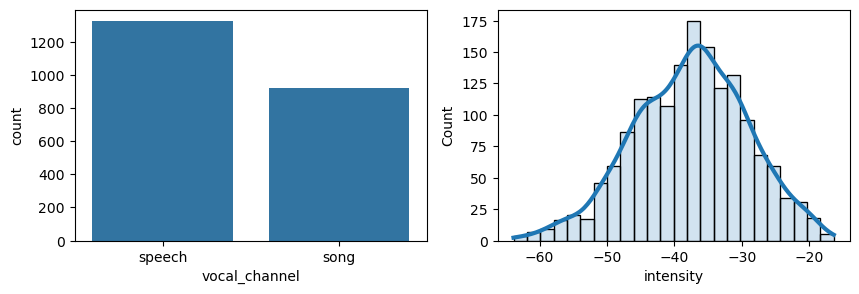

In [ ]:
# rappresnetazione grafica delle colonne 'vocal_channel' e 'intensity' (non lavoriamo su actor, poiché abbiamo deciso di non includerla nell'analisi)
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(data=df_completo, x='intensity', kde=True, line_kws={'color': 'r', 'linewidth': 3},alpha=0.2, ax=axs[1])
sns.countplot(data=df_completo, x='vocal_channel',  ax=axs[0])
plt.show()




<span style="font-size: 18px">

    

#### - *Intensity*


</span>

Per andare a riempire i NaN presenti in questa variabile si è proceduto come segue:

dopo aver notato la presenza di una forte correlazione lineare della variabile 'intensity' con 'mfcc_min' e 'mfcc_std', si è proceduto all'applicazione di una regressione multlineare per trovare i valori mancanti di 'intensity' pertendo dai valori noti di 'mfcc_min' e 'mfcc_std'

In [ ]:
X = df_completo[['mfcc_min','mfcc_std']][df_completo['intensity'].isna().astype(int) == 0]
y = df_completo[['intensity']][df_completo['intensity'].isna().astype(int) == 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# regressione multilineare tra 'intensity' e le variabili 'mfcc_min' e 'mfcc_std'
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('MSE: %.2f' % mean_squared_error(y_test, y_pred))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred))
print('R2: %.2f' % r2_score(y_test, y_pred))
print('MAPE: %.2f' % mean_absolute_percentage_error(y_test, y_pred))

MSE: 2.62
MAE: 1.32
R2: 0.97
MAPE: 0.04


In [ ]:
df_completo['intensity_regr']= df_completo['intensity']
y_pred = reg.predict(df_completo[['mfcc_min','mfcc_std']][df_completo['intensity_regr'].isna()])
y_pred1 = [x[0] for x in y_pred]

# riempiamo i missing values
df_completo['intensity_regr'][df_completo['intensity_regr'].isna()]=y_pred1

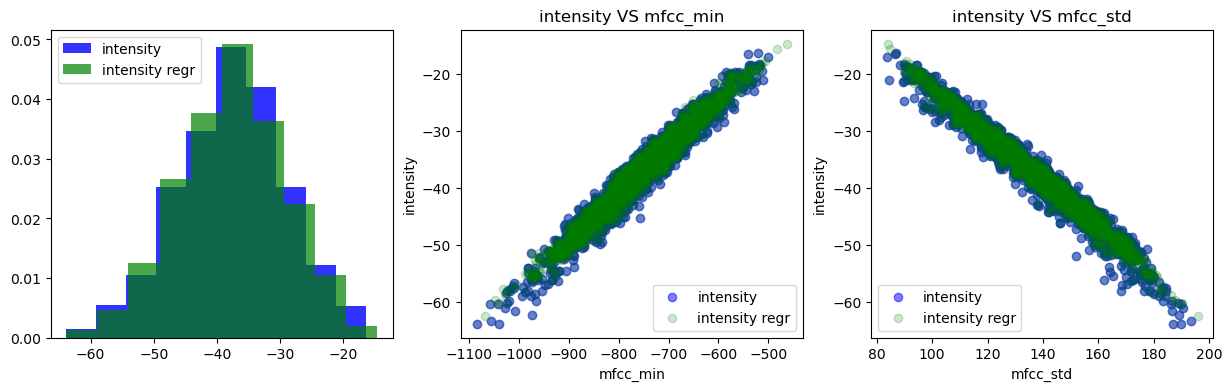

In [ ]:
# da un'analisi dello scatter plot con 'mfcc_min' (si potrebbe fare uguale anche per 'mfcc_std')
# ci siamo accorti che, riempiendo i NaN in modo gaussiano, si distorceva troppo la loro correlazione con 'intensity'
# abbiamo quindi deciso di procedere solo con la regressione
fig, axs = plt.subplots(1, 3, figsize=(15, 4))



axs[0].hist(df_completo['intensity'],label='intensity', density=True, color='b',alpha=0.8)
axs[0].hist(df_completo['intensity_regr'],label='intensity regr', alpha=0.7, density=True, color='g')
axs[0].legend(loc='upper left')



# Disegnare gli scatter plot su ciascun subplot
axs[1].scatter(df_completo['mfcc_min'],df_completo['intensity'], color='b', label = 'intensity', alpha = 0.5)
axs[1].scatter(df_completo['mfcc_min'],df_completo['intensity_regr'] , color='g',label='intensity regr', alpha = 0.2)
axs[1].set_xlabel('mfcc_min')
axs[1].set_ylabel('intensity')
axs[1].legend(loc='lower right')
axs[1].set_title('intensity VS mfcc_min')


axs[2].scatter(df_completo['mfcc_std'],df_completo['intensity'], color='b', label='intensity', alpha = 0.5)
axs[2].scatter(df_completo['mfcc_std'],df_completo['intensity_regr'] , color='g',label='intensity regr', alpha = 0.2)
axs[2].set_xlabel('mfcc_std')
axs[2].set_ylabel('intensity')
axs[2].legend(loc='lower left')
axs[2].set_title('intensity VS mfcc_std')
plt.show()

In [ ]:
# spostiamo tutto su intensity e cancelliamo le colonne superflue
df_completo['intensity']=df_completo['intensity_regr']
df_completo.drop(columns=['intensity_regr'], inplace =True)





<span style="font-size: 18px">

    

#### - *Vocal channel*


</span>

Per trovare i valori mancanti in questa colonna si è proceduto con l'allenare un Random Forest

***

Ai fini del Random Forest è utile introdurre delle nuove colonne dove andremo a convertire le variabili di tipo stringa in numeriche

In [ ]:
col_categoriche = df_completo.select_dtypes(include='object').columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
#transformazione di variabili categoriche in numeriche
encoders={}
for col_name in col_categoriche:
    series = df_completo.select_dtypes(include='object')[col_name]
    label_encoder = LabelEncoder()
    df_completo[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
    )
    encoders[col_name] = label_encoder

In [ ]:
df_completo.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,length_ms,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,stft_skew,mean,std,min,max,kur,skew
0,1.0,3,0,0,1,0,3737,-36.793432,16995,-33.485947,134.654860,-755.22345,171.69092,5792.550744,3328.055457,0.0,13541.959028,-1.120769,0.250940,0.415250,0.335533,0.0,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153
1,1.0,0,0,0,0,0,3904,-34.522763,13906,-29.502108,130.485630,-713.98560,205.00770,5197.620555,4040.931570,0.0,12000.290443,-1.531204,0.219582,0.417488,0.352380,0.0,-1.384174,0.290905,-7.149491e-08,0.020417,-0.305725,0.263062,19.564187,0.292157
2,NaN,4,1,0,1,0,4671,-32.290737,18723,-30.532463,126.577110,-726.06036,165.45653,4830.743037,3332.131300,0.0,12007.751173,-1.130153,0.436699,0.379758,0.352270,0.0,-1.242947,0.470350,2.429985e-06,0.024317,-0.137482,0.166351,4.881241,0.302659
3,NaN,7,0,1,0,0,3637,-49.019839,11617,-36.059555,159.725160,-842.94635,190.03609,5376.446478,4053.663073,0.0,12048.223893,-1.497765,0.098802,0.407277,0.360552,0.0,-1.445318,0.274756,2.373929e-07,0.003561,-0.027374,0.024078,13.040259,-0.081014
4,0.0,4,1,0,1,0,4404,-31.214503,15137,-31.405996,122.125824,-700.70276,161.13400,5146.012474,3442.724109,0.0,12025.582707,-1.167544,0.496066,0.415974,0.350655,0.0,-1.366742,0.318926,8.454691e-07,0.027522,-0.192169,0.242676,7.485109,0.414872


***

In [ ]:
# salviamo gli indici di riga per i quali rispettivamente 'vocal_channel' ha o non ha NaN
index_NaN_vc = df_completo['vocal_channel'].isna().astype(int)!=0

# indici senza NaN su 'vocal_channel'
index_not_NaN_vc = df_completo['vocal_channel'].isna().astype(int)==0

In [ ]:
colonne_da_usare=df_completo.columns.drop(['vocal_channel'])

In [ ]:
# values per i quali 'vocal_channel' NON presenta dei NaN
X = df_completo[index_not_NaN_vc][colonne_da_usare].values
y = df_completo[index_not_NaN_vc]['vocal_channel']

# values per i quali 'vocal_channel' presenta dei NaN
X_missing = df_completo[index_NaN_vc][colonne_da_usare].values

In [ ]:
# separiamo training test e validation con una stratificazione
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [ ]:
# ricerca degli iperparametri ottimali sfruttando optuna
def objective_rf_vc(trial):
    # dizionario dei parametri in cui andare a fare la ricerca
    params = {
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 20, 40)
    }

    # Definizione del modello da allenare
    clf = RandomForestClassifier(**params, random_state=1)
    # Repeated Statified K-Fold Cross Validation
    skf= RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring="accuracy")
    score = np.mean(scores)

    return score

In [ ]:
controllo = False

if controllo:
  study = optuna.create_study(sampler=TPESampler(), direction="maximize")
  study.optimize(objective_rf_vc, n_trials=50, n_jobs=-1, timeout=20000)

  bests=study.best_params

  clf = RandomForestClassifier(**bests)
  clf.fit(X_train, y_train)

  ## Salvataggio del modello su disco
  dump(clf, 'trained_model/rf_vc_model.joblib')

else:
    ## Caricamento del modello
    clf = load('trained_model/rf_vc_model.joblib')



---


**Migliori parametri trovati**

bests = {'max_features': 'log2',
 'min_samples_leaf': 2,
 'bootstrap': False,
 'n_estimators': 452,
 'max_depth': 33}



---



In [ ]:
# accuracy sul test set del modello
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9609236234458259

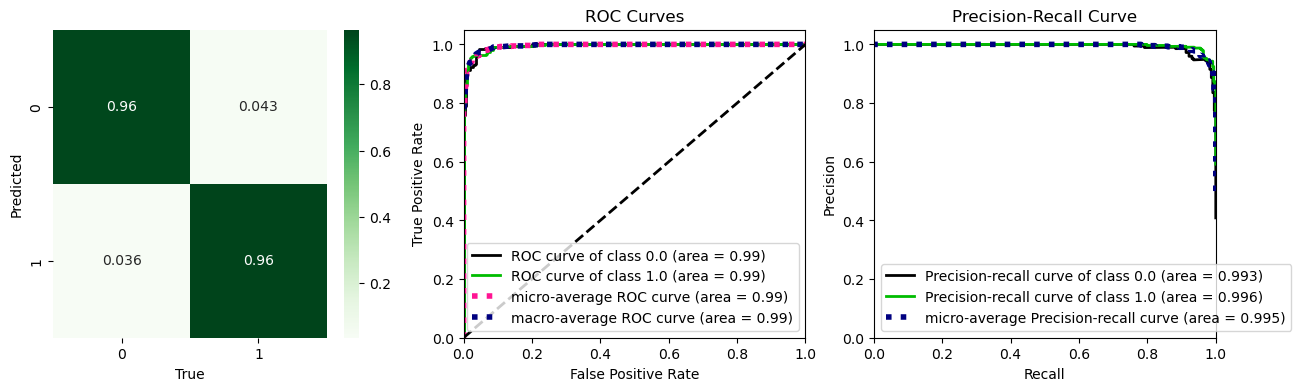

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       230
         1.0       0.97      0.96      0.97       333

    accuracy                           0.96       563
   macro avg       0.96      0.96      0.96       563
weighted avg       0.96      0.96      0.96       563



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)
cf = confusion_matrix(y_test, y_pred, normalize='true')



fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(cf, annot=True, cmap="Greens", ax=axs[0])
axs[0].set_xlabel("True")
axs[0].set_ylabel("Predicted")
plot_roc(y_test,y_test_pred_proba, ax=axs[1])
plot_precision_recall(y_test, y_test_pred_proba , ax=axs[2])
plt.show()



print(classification_report(y_test, y_pred))

In [ ]:
# usiamo il modello allenato per predire i dati mancanti di vocal_channel
V_channel_pred = clf.predict(X_missing)

df_completo['vocal_channel1']=df_completo['vocal_channel']
df_completo['vocal_channel1'][df_completo['vocal_channel'].isna()]=V_channel_pred


In [ ]:
df_completo['vocal_channel']=df_completo['vocal_channel1']
df_completo.drop(columns= 'vocal_channel1', inplace =True)

In [ ]:
for col_name in col_categoriche:
    df_completo[col_name] = encoders[col_name].inverse_transform(df_completo[col_name].astype(int))

***

### **Outliers e PCA**

In [ ]:
df_completo[df_completo.columns[df_completo.isna().any()]].isna().sum()

Series([], dtype: float64)

In [ ]:
col_categoriche = df_completo.select_dtypes(include='object').columns
colonnes_num = df_completo.columns.drop(col_categoriche)
for c in colonnes_num:
    print(c,'--->',perc_outlier(df_completo[c])*100)

length_ms ---> 0.44971381847914965
intensity ---> 0.2861815208503679
zero_crossings_sum ---> 2.125919869174162
mfcc_mean ---> 0.44971381847914965
mfcc_std ---> 0.04088307440719542
mfcc_min ---> 0.5723630417007358
mfcc_max ---> 0.04088307440719542
sc_mean ---> 0.2044153720359771
sc_std ---> 1.2264922322158627
sc_min ---> 0.0
sc_max ---> 17.784137367130008
sc_kur ---> 6.214227309893704
sc_skew ---> 1.4309076042518398
stft_mean ---> 0.12264922322158626
stft_std ---> 1.349141455437449
stft_min ---> 13.695829926410466
stft_kur ---> 2.8618152085036797
stft_skew ---> 0.5723630417007358
mean ---> 21.913327882256745
std ---> 7.031888798037612
min ---> 8.462796402289452
max ---> 8.340147179067865
kur ---> 3.4750613246116107
skew ---> 1.2673753066230582


In [ ]:
# rishiftiamo indietro le kurtosi di 3 e applichiamo una trasformazione logaritmica, questo aiuta a ridurre il numero di outliers
df_completo[['kur', 'sc_kur','stft_kur']]=np.log(df_completo[['kur', 'sc_kur','stft_kur']]+3)

In [ ]:
# analogamente applichiamo la trasformazione logaritmica alle variabili di tipo 'std'
df_completo[['std', 'sc_std','stft_std', 'mfcc_std']]=np.log(df_completo[['std', 'sc_std','stft_std', 'mfcc_std']])

In [ ]:
# Seleziona solo le colonne numeriche
numeric_cols = df_completo.select_dtypes(include=['int64', 'float64']).columns

# Istanzia lo StandardScaler
scaler = StandardScaler()

# Applica lo Scaler alle colonne numeriche
df_completo[numeric_cols] = scaler.fit_transform(df_completo[numeric_cols])

***

#### *PCA*

In [ ]:
col_categoriche = df_completo.select_dtypes(include='object').columns
colonnes_num = df_completo.columns.drop(col_categoriche)

In [ ]:
# salvo in high_coorelation2 le coppie che hanno correlazioni maggiori di 0.8
high_coorelation2=coor_map(df_completo, 0.8)

In [ ]:
# salvo in col_high_corr le colonne che hanno correlazioni maggiori di 0.8
col_high_corr2 = set()
for x in high_coorelation2:
    y = set(x[0:2])
    for t in y:
        col_high_corr2.add(t)

col_high_corr2 = list(col_high_corr2)

L'idea è di usare una PCA su queste variabili fortemente correlate per andare a ridurre la dimensionalità del nostro dataset

In [ ]:
X2 = df_completo[col_high_corr2]

In [ ]:
pn = 3
pca2 = PCA(n_components=pn)
pca2.fit(X2)

PCA(n_components=3)

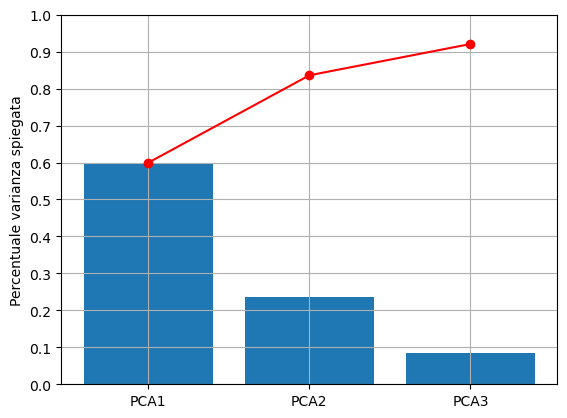

In [ ]:
# come si vede, con sole tre variabili riusciamo a spiegare il 92% della varianza delle 11 variabili originali
plt.bar(np.arange(pn)+1, pca2.explained_variance_ratio_)
plt.plot(np.arange(pn)+1, np.cumsum(pca2.explained_variance_ratio_), c='r', marker='o')
plt.xticks(np.arange(pn)+1,['PCA1', 'PCA2', 'PCA3'])
plt.ylabel('Percentuale varianza spiegata')
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.show()

In [ ]:
X_pca = pca2.transform(X2)

In [ ]:
# sostituiamo le 11 variabili originali con le nuove 3 variabili che abbiamo ottenuto dalla PCA
df_completo.drop(columns=col_high_corr2, inplace=True)
df_completo['PCA1']= X_pca[:, 0]
df_completo['PCA2']= X_pca[:, 1]
df_completo['PCA3']= X_pca[:, 2]

In [ ]:
# check per vedere la percentuale di outliersi nel nostro dataset
col_categoriche = df_completo.select_dtypes(include='object').columns
colonnes_num = df_completo.columns.drop(col_categoriche)
for s in colonnes_num:
    temp = perc_outlier(df_completo[s])
    print(s,"\t--->\t" ,temp*100)

length_ms 	--->	 0.44971381847914965
zero_crossings_sum 	--->	 2.125919869174162
mfcc_mean 	--->	 0.44971381847914965
mfcc_max 	--->	 0.04088307440719542
sc_std 	--->	 4.129190515126738
sc_min 	--->	 0.0
sc_max 	--->	 17.784137367130008
stft_std 	--->	 1.9623875715453802
stft_min 	--->	 13.695829926410466
stft_kur 	--->	 1.9215044971381847
mean 	--->	 21.913327882256745
kur 	--->	 0.6950122649223222
skew 	--->	 1.2673753066230582
PCA1 	--->	 0.776778413736713
PCA2 	--->	 2.1668029435813576
PCA3 	--->	 1.9623875715453802


In [ ]:
df_completo.drop(columns='mean', inplace=True)

In [ ]:
# salvo il dataframe su un file csv che rinomino 'data_esame_NO_missing.csv'
df_completo.to_csv('data/data_esame_trasformato.csv', index=False)

***
***
***